In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set(style='whitegrid')

---
# I. Exploratory Data Analysis

In [3]:
## Loading the data

data_path = "data/"

# Load the data
data = pd.read_csv(data_path+'terrorism_data_30.csv', 
                   header=0, names=['Language', 'Article', 'Date', 'Pageviews'],
                  index_col=0,
                  verbose = True, # Verify if there are any NaNs
                  parse_dates = [2], infer_datetime_format=True)
data_security = pd.read_csv(data_path+'domestic_data.csv', 
                   header=0, names=['Language', 'Article', 'Date', 'Pageviews'],
                  index_col=0,
                  verbose = True, # Verify if there are any NaNs
                  parse_dates = [2], infer_datetime_format=True)


print("\nBelow the parsed data types :\n", data.dtypes)
print("\nData frame of dimensions", data.shape)
print(f"The dataset includes {data.Article.unique().size} different articles.")
print('\n', data.Article.unique(), '\n')
startdate, enddate = data.Date.min().date(), data.Date.max().date()
period = 12 * (enddate.year - startdate.year) + (enddate.month - startdate.month) +1
print(f"The studied period starts the {startdate} to the {enddate} ({period} months).\n")

data.head()

Tokenization took: 7.98 ms
Type conversion took: 3.99 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 6.98 ms
Type conversion took: 4.99 ms
Parser memory cleanup took: 0.00 ms

Below the parsed data types :
 Language             object
Article              object
Date         datetime64[ns]
Pageviews             int64
dtype: object

Data frame of dimensions (29220, 4)
The dataset includes 30 different articles.

 ['abu_sayyaf' 'al-qaeda' 'al-qaeda_in_the_arabian_peninsula'
 'al-qaeda_in_the_islamic_maghreb' 'al-shabaab' 'biological_weapon'
 'car_bomb' 'chemical_weapon' 'conventional_weapon' 'dirty_bomb'
 'eco-terrorism' 'environmental_terrorism' 'euskadi_ta_askatasuna' 'farc'
 'hezbollah' 'improvised_explosive_device' 'islamist' 'jihad' 'nuclear'
 'nuclear_enrichment' 'palestine_liberation_front' 'political_radicalism'
 'recruitment' 'suicide_attack' 'suicide_bomber' 'taliban'
 'tehrik-i-taliban_pakistan' 'terror' 'terrorism' 'weapons-grade'] 

The studied period starts the 2

,Language,Article,Date,Pageviews
1480,en,abu_sayyaf,2012-01-01,254
1,en,al-qaeda,2012-01-01,2688
13000,en,al-qaeda_in_the_arabian_peninsula,2012-01-01,104
13407,en,al-qaeda_in_the_islamic_maghreb,2012-01-01,8
13436,en,al-shabaab,2012-01-01,951


In [4]:
#Understanding the index
print("Are the values in the first column unique ? ", data.index.is_unique)
print("If unique, indicates the first column can be used as an index.\n")

# Sort by index to get articles per date per period
data.sort_index(axis = 0, na_position='first', inplace=True)
data_security.sort_index(axis = 0, na_position='first', inplace=True)

data.head()

Are the values in the first column unique ?  True
If unique, indicates the first column can be used as an index.



,Language,Article,Date,Pageviews
1,en,al-qaeda,2012-01-01,2688
2,en,al-qaeda,2012-01-02,3409
3,en,al-qaeda,2012-01-03,3944
4,en,al-qaeda,2012-01-04,3905
5,en,al-qaeda,2012-01-05,4134


In [5]:
# Language column contains only one value and can be dropped.
print(f"Language column contains {data.Language.unique().size} value(s) : {data.Language.unique()}")
print("It can thus be removed.\n")

data.drop(labels='Language', axis=1, inplace=True)
data_security.drop(labels='Language', axis=1, inplace=True)
data.head()

Language column contains 1 value(s) : ['en']
It can thus be removed.



,Article,Date,Pageviews
1,al-qaeda,2012-01-01,2688
2,al-qaeda,2012-01-02,3409
3,al-qaeda,2012-01-03,3944
4,al-qaeda,2012-01-04,3905
5,al-qaeda,2012-01-05,4134


## A. Cleaning and handling missing/undefined values
Undefined values are any non-positive numerical or non-numerical values. In case of missing values, we will discuss the possible fixes and consequently decide on our way to handle them.

In [6]:
## probably nothing TODO

## B. Consistency in Datasets
Here we will verify that all days were correctly retrieved.

In [7]:
## check that no day is missing on the period

print(f"Startdate: {startdate}")
print(f"Enddate: {enddate}")

# Compute interval +1 to include limit dates on both ends.
interval = (enddate - startdate).days +1
print(f"Time interval in days: {interval}")

# Check there are `interval` number of days for all articles.
art_intervals = all(data.groupby('Article')['Date'].nunique()==974)
print(f'All articles have pageviews for {interval} days: {art_intervals}')

Startdate: 2012-01-01
Enddate: 2014-08-31
Time interval in days: 974
All articles have pageviews for 974 days: True


---
# II. Generic Methods

## A. Monthly Aggregation
The data in our reference paper $\text{Chilling Effects: Online Surveillance and Wikipedia Use}$ (*Jonathan W. Penney*), data is aggregated on a monthly basis and further computations are done on this transformation.

In [8]:
def agg_monthly(df) :
    """
    Aggregates the pageviews in a monthly fashion. Returns a DataFrame with only the numerical columns summed.
    Note : Sets the index to date.
    
    Parameters 
    ----------
    df : pd DataFrame
        df should have at least 3 columns containing `Article`, `Date` and `Pageviews`. Column with `Date` should be named 'Date'.
    """
    # Aggregate monthly
    dataMonthly = df.set_index('Date')
    dataMonthly = dataMonthly.resample('M').sum()
    # Verify period
    print(f"The formatted dataset correctly spans from {dataMonthly.index.min().date()} to {dataMonthly.index.max().date()}.\n")
    
    return dataMonthly

## B. Mean Computation
The first analysis technique done in the paper is a comparison of means before and after the interruption event. Let us write the methods for this purpose given a monthly pageviews dataset.

In [9]:
def divide_around_interruption(df, interruption, verbose=False) :
    """
    Divides the dataset into a pre-interruption dataset and a post-interruption dataset. Returns 2 dataframes in (pre, post) order.
    Note : The month of the interruption is included in the post-interruption dataset.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    """
    # Get pd.Timestamp object
    revelations = pd.to_datetime(interruption)

    # Creating both datasets
    pre = df.loc[df.index < revelations]
    post = df.loc[df.index > revelations]
    if verbose :
        print("Pre-interruption pageviews:\n", pre)
        print("\nPost-interruption pageviews:\n", post)

    # Verifying operation
    if verbose : 
        print("Verifying coherence for split around interruption date...")
    assert(df.size == (pre.size + post.size))
    if verbose :
        print(df.size == (pre.size + post.size))
        
    return pre, post

In [10]:
def compute_mean_around_interruption(df, interruption, verbose=False) :
    """
    Computes the mean number of pageviews before and after the interruption date. 
    Returns 2 means (2-tuple of numpy.float64) in (pre, post) order.
    Note : The month of the interruption is included in the post-interruption dataset.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    """
    pre, post = divide_around_interruption(df, interruption, verbose=verbose)
    return pre.mean()[0], post.mean()[0]

## C. ITS Regression 
Following the formula of segmented regression of an interrupted time series (ITS) : 
$$
Y_{t} = \beta_{0}*\text{time}+\beta_{2}*\text{intervention}+\beta_{3}*\text{postslope}+\epsilon_{1}
$$
We define in the following the methods to perform such a regression.

In [11]:
def fit_model(formula, data, predictor, seed):
    '''
    Output a linear prediciton using an ordinary least squares linear regression.
    :param string formula: the equation describing the model using patsy formula syntax
    :param pd.DataFrame data: the dataframe containing the monthly grouped time series elements for fitting
    :param pd.DataFrame predictors: the dataframe containing the monthly grouped time series elements for predicting
    :param int seed: a seed for consistency
    '''
    # Declares model
    mod = smf.ols(formula=formula, data=data)

    # Fits the model (finds the optimal coefficients, adding a random seed for consistency)
    np.random.seed(seed)
    res = mod.fit()

    # Optimal Coefficients
    coefficients = res.params.values

    # Compute predictions
    ypred = res.predict(predictor)
    return ypred

In [12]:
def monthly_views_formatting(df, reference_point):
    '''
    Computes the dataframe containing the monthly grouped time series elements
    :param pd.DataFrame df: the dataframe containing the daily time series elements
    :param int reference_point: the time series interruption event
    '''
    # Create indexing for visualizing correctly on x-axis of the plot
    g = df.copy()
    g = g.reset_index()
    g['index'] = g['index']+1
    g['XT'] = np.where(g['index'] < reference_point, 0, g['index']-reference_point)
    g['X'] = [0 if x < reference_point else 1 for x in g.index] 
    return g

## D. Plotting
The reference paper uses 3 types of plots to describe the results :
* **Histogram** of means before and after the interruption event (*cf. figure 1 in reference paper*).
* **Segmented regression** around the interrupted event for **1 set** of articles (*cf. figure 2 in reference paper*).
* **Segmented regression** around the interrupted event for **2 sets** of articles (*cf. figure 4A in reference paper*).

Additionally, the regression plots can feature confidence intervals if prompted by the user (cf. figure 4 in reference paper).

In [13]:
def hist_mean(df, interruption, verbose=False, ytick_step=5e5) :
    """
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    ytick_step : int (default: 5e5)
        Step in pageviews between 2 ticks on the y axis
    """
    # Get means around interruption
    pre, post = compute_mean_around_interruption(df, interruption)
    pre_int, post_int = int(pre), int(post)
    
    # Preparing labels and data
    d = np.array([pre,post])
    rev_date= pd.to_datetime(interruption).month_name()+', '+str(pd.to_datetime(interruption).year)
    l = ['Pre-'+rev_date, 'Post-'+rev_date]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(5,6))
    plt.bar(x=l, height=d, width=0.5)
    
    # Configuring the axes to fit the data
    ymax = np.floor(d.max()/ytick_step +3)*ytick_step
    plt.yticks(np.arange(0, ymax, ytick_step), [f'{v:,}' for v in np.arange(0, ymax, ytick_step, dtype=int)])
    plt.ylabel('Total Views', labelpad=30)
    
    plt.grid(False)
    plt.show()
    
    return None

In [26]:
def segmented_reg_1_set(df, interruption, verbose=False, ytick_step=5e5, narts=None) :
    """
    Plots the ITS of a dataset of monthly Pageviews around an interruption date.
    
    Parameters 
    ----------
    df : pd DataFrame
        Pandas DataFrame containing the monthly pageviews around the interruption date.
    interruption : string
        Interruption date in the form of a string. Please use following fashion :
        1st of May 1997 --> 1995-05-01
    verbose : bool (default: False)
        Display temp dataframes created in the process and other insightful information from the process.
    ytick_step : int (default: 5e5)
        Step in pageviews between 2 ticks on the y axis
    narts : int (default: None)
        Number of articles summed in the monthly Pageviews. Used for the legend.
    """
    # Divide around interruption
    pre, post = divide_around_interruption(df, interruption, verbose=verbose)
        
    ## Plotting
    
    # Create dataframe with both periods identified
    concatenated = pd.concat([
        pre.reset_index(drop=True).assign(period='pre'), 
        post.reset_index(drop=True).assign(period='post')], ignore_index=True)

    # Creating a month-identifier column
    concatenated = concatenated.reset_index()
    concatenated.columns.values[0]='Months'
    concatenated['Months'] = concatenated['Months']+1
    # The paper shifts monthly count to start from 1.

    # Identifying both periods visually
    pal = dict(pre="black", post="grey")
    g = sns.FacetGrid(concatenated, hue='period', palette=pal, height=5, aspect=1.5, xlim=(-1, 33))

    #### TODO use computed regression !
    # Creating the regressions for both periods
    g.map(sns.regplot, "Months", "Pageviews", ci=None, robust=1, scatter=False)

    # Adding the scatter data separately
    g.map(sns.scatterplot,  "Months", "Pageviews", color="black")

    # Configuring the axes to fit the data
    plt.xticks(np.arange(0, concatenated.shape[0]+2, 2), np.arange(0, concatenated.shape[0]+2, 2, dtype=int))
    ymin, ymax = np.floor(concatenated['Pageviews'].min()/ytick_step)*ytick_step, np.floor(concatenated['Pageviews'].max()/ytick_step +1)*ytick_step
    plt.yticks(np.arange(ymin, ymax, ytick_step), np.arange(ymin, ymax, ytick_step, dtype=int))

    # Configuring the labels to be as on paper
    plt.ylabel("Total Views"+ ( '('+narts+' Wikipedia Articles)' if narts else ''))
    plt.xlabel("Time (Months)")

    # Adding grid to be as on paper
    plt.grid(True, which='major', axis='y', alpha=0.3)

    # Creating legend
    rev_date= pd.to_datetime(interruption).month_name()+', '+str(pd.to_datetime(interruption).year)
    legend = plt.legend(labels=["Trend Pre-"+rev_date, "Trend Post-"+rev_date, "Total Article Views (per month)"], 
                        bbox_to_anchor=[1,-0.1], fontsize='medium', 
                        ncol=2, borderpad=0.75, handlelength=5)

    # Adding June 2013 line identifier
    plt.text(17.5,4.2e6,'Mid '+rev_date,horizontalalignment='center')
    plt.axvline(17.5, linewidth=2.5, color='black')

    plt.show()

In [15]:
def bootstrap_CI(df, nbr_draws):
    '''
    A bootstrapping function for obtaining a 95% confidence intervals [lower error, upper error] 
    around the monthly estimated average.
    :param pd.DataFrame df: the dataframe containing the time series elements
    :param int nbr_draws: the number of random samples
    '''
    means = np.empty((0,len(df)))
    group_means= np.empty((0, 2))
    for n in range(nbr_draws):
        indices = np.random.randint(0, len(df), len(df))
        data_tmp = df.iloc[indices].sort_values(by='index')
        ypredi = fit_model('Pageviews ~ index + C(X) + XT', data=data_tmp, predictor=df, seed=n)
        means = np.concatenate((means, np.array([ypredi])), axis = 0)
    for i in range(len(df)):
        group_means = np.append(group_means, np.array([[np.nanpercentile(means[:,i], 2.5), np.nanpercentile(means[:,i], 97.5)]]), axis=0)
    return group_means

In [16]:
def plot_trends_confidence_intervals(df, reference_point, ypred, y_error, color):
    '''
    Plot the monthly time series and regressions with the confidence interval for the 
    given dataset and its interruption moment.
    :param pd.DataFrame df: the dataframe containing the time series elements
    :param int reference_point: the interruption month's index
    :param pandas.Series ypred: the trend values following the ITS regression model
    :param numpy.ndarray y_error: the lower and upper 95% confidence interval
    :param string color: the color for plotting
    '''
    plt.plot(df['index'][:reference_point], ypred[:reference_point], color=color, linestyle='-')
    plt.plot(df['index'][reference_point:], ypred[reference_point:], color=color, linestyle='--')
    plt.fill_between(df['index'][reference_point:], y_error[:,0][reference_point:], y_error[:,1][reference_point:], color=color, alpha=0.1)
    plt.fill_between(df['index'][:reference_point], y_error[:,0][:reference_point], y_error[:,1][:reference_point], color=color, alpha=0.1)

In [31]:
def plotting(intervention, treatment, control, reference_point, treatment_df, treatment_pred, treatment_error, control_df, control_pred, control_error):
    '''
    Plot the monthly time series and regressions with the confidence interval for the 
    given dataset and its interruption moment with labels
    :param string intervention: name of intervention event
    :param string treatment: name of treatment group
    :param string control: name of control group
    :param int reference_point: the intervention month's index
    :param pd.DataFrame treatment_df: the treatment dataframe containing the time series elements
    :param pandas.Series treatment_pred: the predicted trend values following the ITS regression model of the treatment group
    :param numpy.ndarray treatment_error: the lower and upper 95% confidence interval of the treatment group
    :param pd.DataFrame control_df: the control dataframe containing the time series elements
    :param pandas.Series control_pred: the predicted trend values following the ITS regression model of the control group
    :param numpy.ndarray control_error: the lower and upper 95% confidence interval of the control group
    '''
    
    # Initialize plot style
    sns.set_style("darkgrid")

    # Plot trends
    plot_trends_confidence_intervals(treatment_df, reference_point, treatment_pred, treatment_error, 'tab:orange')
    plot_trends_confidence_intervals(control_df, reference_point, control_pred, control_error, 'tab:blue')

    # Add Labels
    plt.xlabel(f"Time [Months]")
    plt.ylabel(f"Total Views (All Articles)")
    plt.title(intervention);

    # Plot scatter points 
    sns.scatterplot(data=treatment_df, x="index", y="Pageviews", color='tab:orange')
    sns.scatterplot(data=control_df, x="index", y="Pageviews", color='tab:blue')

    # Add Legend
    plt.legend(bbox_to_anchor=(-0.1, -0.55, 1.2, .102), loc='lower center',
               ncol=2, mode="expand", borderaxespad=0., 
               labels = [treatment + ' Article Trend Pre-' + intervention, treatment + ' Article Trend Post-' + intervention,
                         control + ' Article Trend Pre-' + intervention, control + ' Article Trend Post-' + intervention,
                         'Confidence Interval Pre-' + intervention, 'Confidence Interval Post-' + intervention, 
                         'Confidence Interval Pre-' + intervention, 'Confidence Interval Post-' + intervention,
                         treatment + ' Articles Views (By Month)', control + ' Articles Views (By Month)'])

    # Mark mid-June 2013
    plt.axvline(reference_point+0.5, 0, color='black', lw=2)

---
# III. GDPR Adoption
The European Parliament adopted the GDPR Regulation text on the $27^{th}$ of April $2016$. Our first case of interest are the following research questions at this date : 
* Is there an inverse chilling effect (e.g. immediate spike) following the announcement of the regulation adoption?
* Has there been a change in trends in the viewing of critical terms related to the regulation after the event?

We will thus answer these questions using the analysis methods from the reference paper and draw conclusions.

## A. Monthly Aggregation

In [18]:
# Reference point is the month of June 2013
reference_point = 17

# Count the total number of views of 47 wikipedia article per month.
g = agg_monthly(data).reset_index()
g_security = agg_monthly(data_security).reset_index()

The formatted dataset correctly spans from 2012-01-31 to 2014-08-31.

The formatted dataset correctly spans from 2012-01-31 to 2014-08-31.



In [21]:
# Compute trends predictions for terrorism datasets
temp = monthly_views_formatting(g, 17)
ypred = fit_model(formula='Pageviews ~ index + C(X) + XT', data=temp, predictor=temp, seed=2)

# Compute trends predictions for domestic security-related datasets
temp_security = monthly_views_formatting(g_security, 17)
ypred_security = fit_model(formula='Pageviews ~ index + C(X) + XT', data=temp_security, predictor=temp_security, seed=2)

ypred.head()

0    584675.509804
1    625246.850490
2    665818.191176
3    706389.531863
4    746960.872549
dtype: float64

## B. Mean Computation

The formatted dataset correctly spans from 2012-01-31 to 2014-08-31.



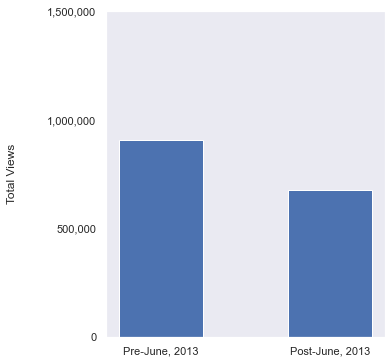

In [35]:
hist_mean(agg_monthly(data),'2013-06-06')

## C. ITS Regression

The formatted dataset correctly spans from 2012-01-31 to 2014-08-31.



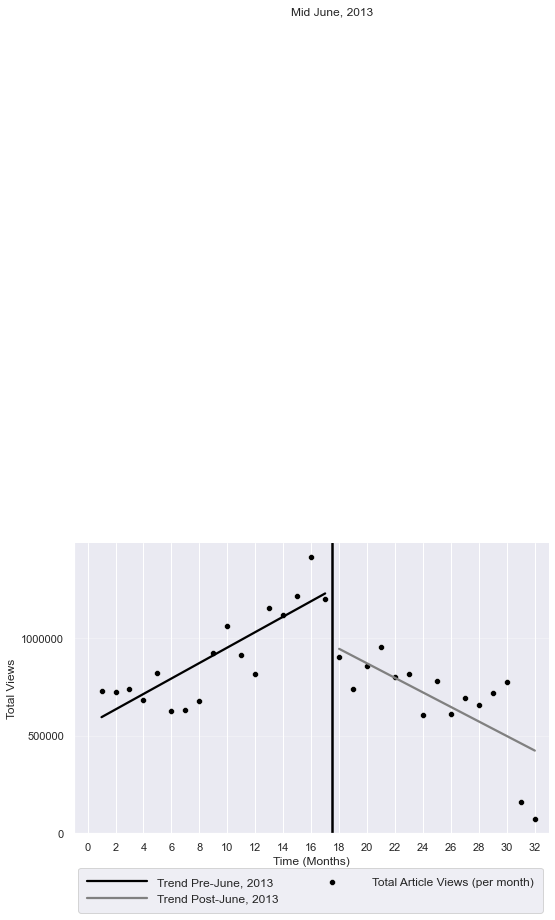

In [34]:
segmented_reg_1_set(agg_monthly(data),'2013-06-06')

In [28]:
# Compute 95% confidence intervals for each monthly estimated average
y_error_terrorism = bootstrap_CI(temp, 200)
y_error_security = bootstrap_CI(temp_security, 200)

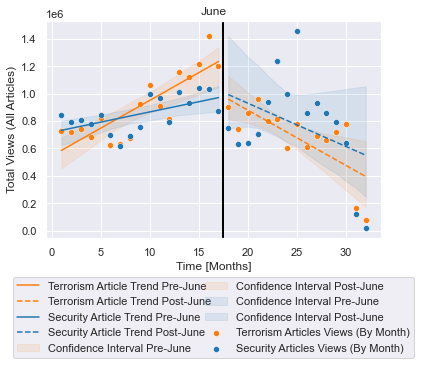

In [32]:
plotting('June', 'Terrorism', 'Security', reference_point, temp, ypred, y_error_terrorism, temp_security, ypred_security, y_error_security)

---
# GPDR Begginig of enforcement
The GDPR regulation was applied starting from the $25^{th}$ of May $2018$ for every country of the European Union (EU) and European Economic Area (EEA). We aim to answer the following questions regarding the event : 
* Is there an inverse chilling effect (e.g. immediate spike) following the day when the regulation became effective?
* Has there been a change in trends in the viewing of critical terms related to the regulation after the event?

We will thus answer these questions using the analysis methods from the reference paper and draw conclusions.

## A. Monthly Aggregation

## B. Mean Computation

## C. ITS Regression

# Conclusion